In [1]:
import datetime          as dt
import math              as mt
import matplotlib        as mpl
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

In [2]:
def centered_moving_average(data,window_size):
    if window_size %2 == 0:
        print('only odd window sizes currently supported')
        return
    else:
        w = int((window_size-1)/2)
    N = len(data)
    #pre-allocate the array
    ma = np.zeros(N)
    #pack NaN's in the spots where we can't compute a moving average 
    #because we are near the boundaries of the data
    for i in range(w):
        ma[i]     = np.NaN
        ma[N-1-1] = np.NaN    
    for i in range(w,N-w):
        ma[i] = np.nanmean(data[i-w:i+w]) #use nanmean to exclude NaN's from the average

    return ma

def trailing_moving_average(data,window_size):
    N = len(data)
    w = window_size
    #pre-allocate the array
    ma = np.zeros(N)
    #pack NaN's in the spots where we can't compute a moving average 
    #because we are near the lower boundary of the data
    for i in range(w):
        ma[i]     = np.NaN
    for i in range(w,N):
        ma[i] = np.nanmean(data[i-w:i]) #use nanmean to exclude NaN's from the average
    return ma

def simple_exponential_smoothing(data,alpha):
    N     = len(data)
    #pre-allocate the array
    L     = np.zeros(N)
    L[0]  = np.nanmean(data)
    for i in range(1,N):
        L[i] = alpha*data[i] + (1-alpha)*L[i-1]
        
    return L

def initialize_holt_winter(dataframe,data_column_str,P):
    #Holt Winter Steps 1-4
    
    #point to relevant data in the dataframe
    data = dataframe[data_column_str].iloc[0:P]
    
    #find first period average value (over P elements) for use in the level
    #and the ratio of each segment (P of these) to that average for seasonal use
    A    = np.mean(data[0:P])
    S_1i = np.array(data[0:P])/A

    #initialize the seasonal array to S_1i (over P elements)
    #the idea is that the ratio says how the season scales relative to a yearly average
    seasonal = S_1i*np.ones(P)
    
    #initialize the level array to the seationally scaled version (should equal A)
    level = data[0:P]/S_1i
    
    #initialize the trend as a finite difference with the first element set to NaN
    trend      = np.NaN*np.ones(P)
    trend[1:P] = [level[j] - level[j-1] for j in range(1,P)]
    
    #pack the data into the dataframe
    #return level, trend, seasonal
    dataframe['level']    = np.zeros(len(dataframe))
    dataframe['trend']    = np.zeros(len(dataframe))
    dataframe['seasonal'] = np.zeros(len(dataframe))
    
    dataframe['level'].iloc[0:P]    = level
    dataframe['trend'].iloc[0:P]    = trend
    dataframe['seasonal'].iloc[0:P] = seasonal
    

def bootstrap_holt_winter(dataframe,data_column_str,P,alpha,beta,gamma):
    #Step 5 - Bootstrap
    #note that alpha and beta are not used but are passed in to give a common
    #calling sequence with update_holt_winter
    
    #get the average of the first period (P elements)
    A    = np.mean(dataframe[data_column_str][0:P])

    #move to the first forecasting interval
    i = P

    #remember the past
    prev_interval = i - 1
    prev_season   = i - P
    prev_level    = A
    prev_seasonal = dataframe['seasonal'].iloc[prev_season]

    #bootstrap the current values
    cur_data      = dataframe[data_column_str].iloc[i]
    cur_level     = cur_data/prev_seasonal
    cur_trend     = cur_level - prev_level
    cur_seasonal  = gamma*(cur_data/cur_level) + (1-gamma)*prev_seasonal

    #archive data
    dataframe['level'].iloc[i]    = cur_level
    dataframe['trend'].iloc[i]    = cur_trend
    dataframe['seasonal'].iloc[i] = cur_seasonal
    
def iterate_holt_winter(dataframe,data_column_str,P,alpha,beta,gamma,i):
    #remember the past
    prev_level         = dataframe['level'].iloc[i-1]
    prev_trend         = dataframe['trend'].iloc[i-1]
    prev_seasonal      = dataframe['seasonal'].iloc[i-P]
    
    #bootstrap the current values
    cur_data           = dataframe[data_column_str].iloc[i]
    cur_seasonal_guess = prev_seasonal
    cur_level_guess    = cur_data/cur_seasonal_guess
    cur_level          = alpha*cur_level_guess + (1-alpha)*(prev_level+prev_trend)
    cur_trend          = beta*(cur_level-prev_level) + (1-beta)*prev_trend
    cur_seasonal       = gamma*cur_data/cur_level + (1-gamma)*prev_seasonal
    
    #archive data
    dataframe['level'].iloc[i]    = cur_level
    dataframe['trend'].iloc[i]    = cur_trend
    dataframe['seasonal'].iloc[i] = cur_seasonal

In [3]:
RF = pd.read_csv('Redfin_home_sales.csv')
#put the dates in objects for easier use
RF['dates'] = [dt.datetime.strptime(i,'%B %Y') for i in RF['Month of Period End']]

In [4]:
#description of the home sales intervals
P = 12
M = 1

#Holt-Winter estimation parameters
alpha = 0.2
alpha = 0.4
beta  = 0.2
gamma = 0.5

In [5]:
initialize_holt_winter(RF,'Homes Sold',12)
bootstrap_holt_winter(RF,'Homes Sold',P,alpha,beta,gamma)

C:\Users\byecs\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [6]:
forecasts = {}
long_forecasts = {}
for i in range(P,len(RF)):
    iterate_holt_winter(RF,'Homes Sold',P,alpha,beta,gamma,i)
    l = RF['level'].iloc[i]
    t = RF['trend'].iloc[i]
    e = RF['Month of Period End'].iloc[i]
    forecasts[e]      = [ (l + k *t)*RF['seasonal'].iloc[i-P+k] for k in range(1,P+1)]

for i in range(P,len(RF)-P):
    l = RF['level'].iloc[i]
    t = RF['trend'].iloc[i]
    e = RF['Month of Period End'].iloc[i]
    long_forecasts[e] = [ (l + k *t)*RF['seasonal'].iloc[i-P+k] for k in range(1,P+13)]

In [7]:
best_for = []
for key in forecasts:
    best_for.append(forecasts[key][0])
best_for = np.array(best_for)    

In [8]:
best_for

array([401011.34601638, 421003.05593347, 505702.47972064, 550331.14297815,
       504294.44655706, 569479.01125417, 454239.46274102, 491625.34317054,
       446967.89911242, 409080.0562752 , 321293.40442971, 306488.26339996,
       388678.08153911, 398471.30241351, 467648.16622354, 490739.80461932,
       492599.57897937, 529958.1985192 , 431256.51585225, 475630.21570084,
       446787.1271044 , 429922.90369096, 341049.72893429, 330982.17936218,
       423062.38077056, 466782.05170969, 539107.70897182, 555419.21952984,
       565315.59929191, 597036.45825214, 500051.18555299, 532900.27097559,
       458486.56848107, 470035.66998252, 358330.33291985, 366512.75291536,
       475195.01373631, 506660.63383225, 567608.82549148, 611586.27349321,
       598543.83875005, 565103.52411759, 514326.78716916, 531097.97792159,
       446790.01551495, 533996.92073243, 381805.53786951, 395696.615279  ,
       503008.51701288, 548345.25469791, 588055.6892861 , 645943.71429627,
       608682.11456178, 5

# First Figure - Home Sales Overview

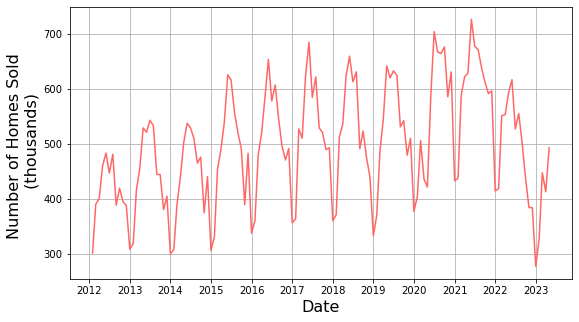

In [9]:
dates = [mpl.dates.date2num(dt.date(i,1,1)) for i in range(2011,2024)]
fig_home_sales = plt.figure(figsize=(9,5))
ax_home_sales  = fig_home_sales.add_subplot(1,1,1)
ax_home_sales.plot(RF['dates'],RF['Homes Sold']/1000,color="#ff6666")
#x-axis
ax_home_sales.xaxis.set_major_locator(mpl.ticker.FixedLocator(dates))
ax_home_sales.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
#yaxis
ax_home_sales.set_ylabel('Number of Homes Sold \n (thousands)',fontsize=16)
ax_home_sales.set_xlabel('Date',fontsize=16)
ax_home_sales.grid('on')
fig_home_sales.savefig('A2D_02(Feb)_2024_RedFin_home_sales_overview.png')

# Second Figure - Median Home Price Overview

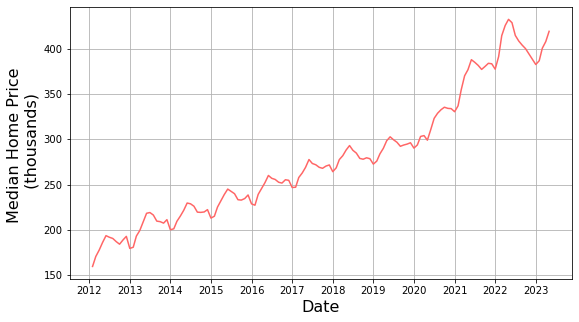

In [10]:
dates = [mpl.dates.date2num(dt.date(i,1,1)) for i in range(2011,2024)]
fig_home_prices = plt.figure(figsize=(9,5))
ax_home_prices  = fig_home_prices.add_subplot(1,1,1)
ax_home_prices.plot(RF['dates'],RF['Median Sale Price']/1000,color="#ff6666")
#x-axis
ax_home_prices.xaxis.set_major_locator(mpl.ticker.FixedLocator(dates))
ax_home_prices.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
#yaxis
ax_home_prices.set_ylabel('Median Home Price \n (thousands)',fontsize=16)
ax_home_prices.set_xlabel('Date',fontsize=16)
ax_home_prices.grid('on')
fig_home_prices.savefig('A2D_02(Feb)_2024_RedFin_home_median_prices_overview.png')

# Third Figure - Centered Moving Average

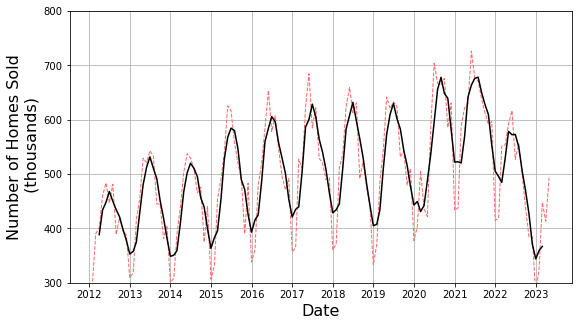

In [11]:
home_sales_CMA = centered_moving_average(RF['Homes Sold'],5)
dates = [mpl.dates.date2num(dt.date(i,1,1)) for i in range(2011,2024)]
fig_home_sales2 = plt.figure(figsize=(9,5))
ax_home_sales2  = fig_home_sales2.add_subplot(1,1,1)
ax_home_sales2.plot(RF['dates'],RF['Homes Sold']/1000,color="#ff6666",linestyle='--',linewidth=1)
ax_home_sales2.plot(RF['dates'],home_sales_CMA/1000,'k-')
#x-axis
ax_home_sales2.xaxis.set_major_locator(mpl.ticker.FixedLocator(dates))
ax_home_sales2.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
#yaxis
ax_home_sales2.set_ylabel('Number of Homes Sold\n (thousands)',fontsize=16)
ax_home_sales2.set_xlabel('Date',fontsize=16)
ax_home_sales2.grid('on')
#ax_home_sales2.axhline(np.mean(RF['Homes Sold'])/1000,color='black')
ax_home_sales2.set_ylim([300,800])
fig_home_sales2.savefig('A2D_02(Feb)_2024_RedFin_home_sales_and_CMA.png')

# Fourth Figure - Exponential Smoothing $\alpha = 0.4$

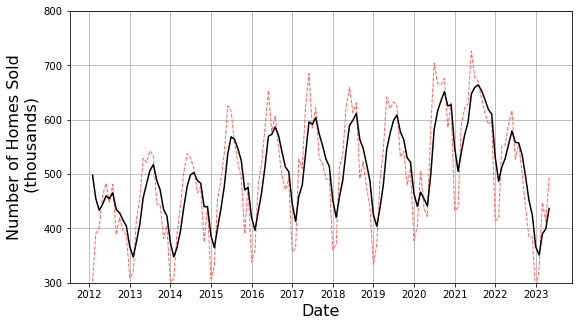

In [12]:
home_sales_exp = simple_exponential_smoothing(RF['Homes Sold'],0.4)
dates = [mpl.dates.date2num(dt.date(i,1,1)) for i in range(2011,2024)]
fig_home_sales2 = plt.figure(figsize=(9,5))
ax_home_sales2  = fig_home_sales2.add_subplot(1,1,1)
ax_home_sales2.plot(RF['dates'],RF['Homes Sold']/1000,color="#ff6666",linestyle='--',linewidth=1)
ax_home_sales2.plot(RF['dates'],home_sales_exp/1000,'k-')
#x-axis
ax_home_sales2.xaxis.set_major_locator(mpl.ticker.FixedLocator(dates))
ax_home_sales2.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
#yaxis
ax_home_sales2.set_ylabel('Number of Homes Sold\n (thousands)',fontsize=16)
ax_home_sales2.set_xlabel('Date',fontsize=16)
ax_home_sales2.grid('on')
#ax_home_sales2.axhline(np.mean(RF['Homes Sold'])/1000,color='black')
ax_home_sales2.set_ylim([300,800])
fig_home_sales2.savefig('A2D_02(Feb)_2024_RedFin_home_sales_and_exp_0_4.png')

# Fifth Figure - Exponential Smoothing $\alpha = 0.2$

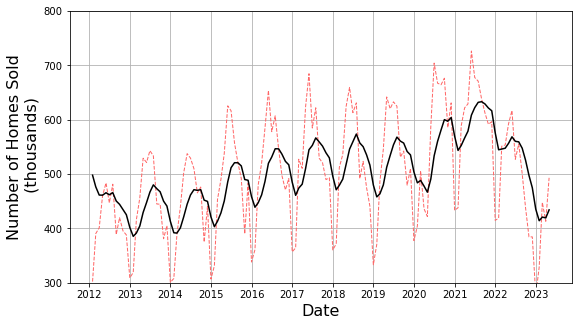

In [13]:
home_sales_exp = simple_exponential_smoothing(RF['Homes Sold'],0.2)
dates = [mpl.dates.date2num(dt.date(i,1,1)) for i in range(2011,2024)]
fig_home_sales2 = plt.figure(figsize=(9,5))
ax_home_sales2  = fig_home_sales2.add_subplot(1,1,1)
ax_home_sales2.plot(RF['dates'],RF['Homes Sold']/1000,color="#ff6666",linestyle='--',linewidth=1)
ax_home_sales2.plot(RF['dates'],home_sales_exp/1000,'k-')
#x-axis
ax_home_sales2.xaxis.set_major_locator(mpl.ticker.FixedLocator(dates))
ax_home_sales2.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
#yaxis
ax_home_sales2.set_ylabel('Number of Homes Sold\n (thousands)',fontsize=16)
ax_home_sales2.set_xlabel('Date',fontsize=16)
ax_home_sales2.grid('on')
#ax_home_sales2.axhline(np.mean(RF['Homes Sold'])/1000,color='black')
ax_home_sales2.set_ylim([300,800])
fig_home_sales2.savefig('A2D_02(Feb)_2024_RedFin_home_sales_and_exp_0_2.png')

# Sixth Figure - Feb 2015 Prediction

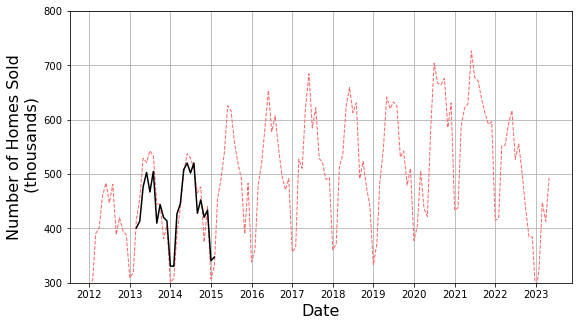

In [19]:
dates = [mpl.dates.date2num(dt.date(i,1,1)) for i in range(2011,2024)]
fig_home_sales3 = plt.figure(figsize=(9,5))
ax_home_sales3  = fig_home_sales3.add_subplot(1,1,1)
ax_home_sales3.plot(RF['dates'],RF['Homes Sold']/1000,color="#ff6666",linestyle='--',linewidth=1)
ax_home_sales3.plot(RF['dates'].iloc[13:37],np.array(long_forecasts['February 2013'])/1000,'k-')
#x-axis
ax_home_sales3.xaxis.set_major_locator(mpl.ticker.FixedLocator(dates))
ax_home_sales3.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
#yaxis
ax_home_sales3.set_ylabel('Number of Homes Sold\n (thousands)',fontsize=16)
ax_home_sales3.set_xlabel('Date',fontsize=16)
ax_home_sales3.grid('on')
#ax_home_sales3.axhline(np.mean(RF['Homes Sold'])/1000,color='black')
ax_home_sales3.set_ylim([300,800])
fig_home_sales3.savefig('A2D_02(Feb)_2024_RedFin_home_sales_and_Feb_2013_long_forecast.png')

# Seventh Figure - Jun 2017 Prediction

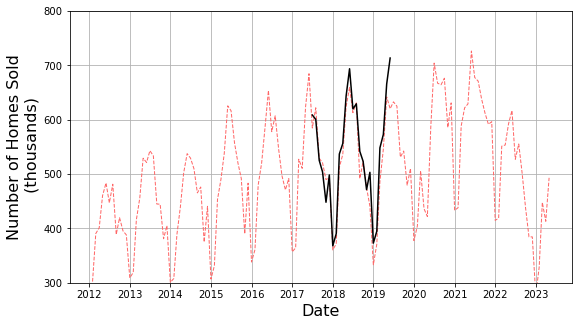

In [18]:
dates = [mpl.dates.date2num(dt.date(i,1,1)) for i in range(2011,2024)]
fig_home_sales4 = plt.figure(figsize=(9,5))
ax_home_sales4  = fig_home_sales4.add_subplot(1,1,1)
ax_home_sales4.plot(RF['dates'],RF['Homes Sold']/1000,color="#ff6666",linestyle='--',linewidth=1)
ax_home_sales4.plot(RF['dates'].iloc[65:89],np.array(long_forecasts['June 2017'])/1000,'k-')
#x-axis
ax_home_sales4.xaxis.set_major_locator(mpl.ticker.FixedLocator(dates))
ax_home_sales4.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
#yaxis
ax_home_sales4.set_ylabel('Number of Homes Sold\n (thousands)',fontsize=16)
ax_home_sales4.set_xlabel('Date',fontsize=16)
ax_home_sales4.grid('on')
#ax_home_sales4.axhline(np.mean(RF['Homes Sold'])/1000,color='black')
ax_home_sales4.set_ylim([300,800])
fig_home_sales4.savefig('A2D_02(Feb)_2024_RedFin_home_sales_and_Jun_2017_long_forecast.png')

# Eight Figure - 1 Month Prediction

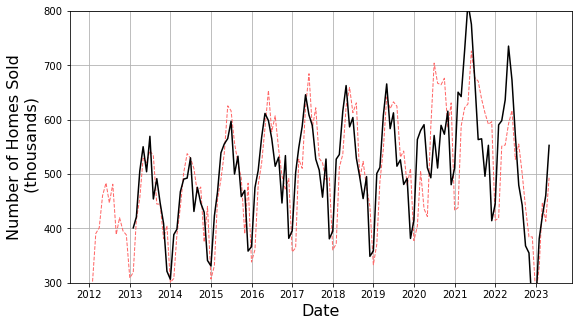

In [16]:
dates = [mpl.dates.date2num(dt.date(i,1,1)) for i in range(2011,2024)]
fig_home_sales5 = plt.figure(figsize=(9,5))
ax_home_sales5  = fig_home_sales5.add_subplot(1,1,1)
ax_home_sales5.plot(RF['dates'],RF['Homes Sold']/1000,color="#ff6666",linestyle='--',linewidth=1)
ax_home_sales5.plot(RF['dates'].iloc[P:],best_for/1000,'k-')
#x-axis
ax_home_sales5.xaxis.set_major_locator(mpl.ticker.FixedLocator(dates))
ax_home_sales5.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
#yaxis
ax_home_sales5.set_ylabel('Number of Homes Sold\n (thousands)',fontsize=16)
ax_home_sales5.set_xlabel('Date',fontsize=16)
ax_home_sales5.grid('on')
#ax_home_sales5.axhline(np.mean(RF['Homes Sold'])/1000,color='black')
ax_home_sales5.set_ylim([300,800])
fig_home_sales5.savefig('A2D_02(Feb)_2024_RedFin_home_sales_and_short_forecast.png')

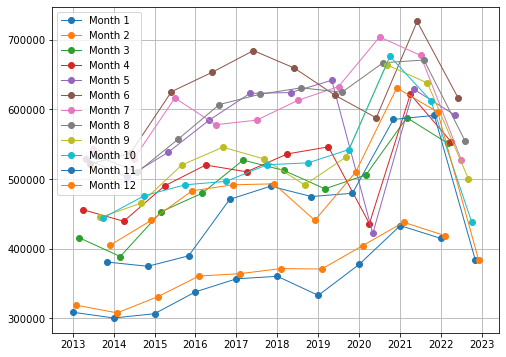

In [17]:
start_month_slot   = 11
stop_month_slot    = 131
year_size_in_slots = 12
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(1,1,1)
for i in range(1,13):
    t = RF['dates'][start_month_slot+(i-1):stop_month_slot:year_size_in_slots]
    Q = RF['Homes Sold'][start_month_slot+(i-1):stop_month_slot:year_size_in_slots]
    ax.plot(t,Q,marker='o',linewidth=1,label=f'Month {i}')
ax.grid('on')
ax.legend()

(300.0, 800.0)

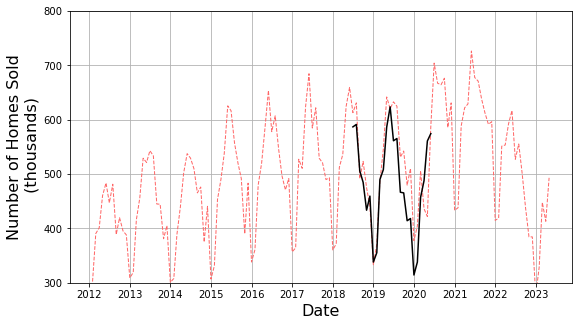

In [20]:
dates = [mpl.dates.date2num(dt.date(i,1,1)) for i in range(2011,2024)]
fig_home_sales4 = plt.figure(figsize=(9,5))
ax_home_sales4  = fig_home_sales4.add_subplot(1,1,1)
ax_home_sales4.plot(RF['dates'],RF['Homes Sold']/1000,color="#ff6666",linestyle='--',linewidth=1)
ax_home_sales4.plot(RF['dates'].iloc[77:101],np.array(long_forecasts['June 2018'])/1000,'k-')
#x-axis
ax_home_sales4.xaxis.set_major_locator(mpl.ticker.FixedLocator(dates))
ax_home_sales4.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
#yaxis
ax_home_sales4.set_ylabel('Number of Homes Sold\n (thousands)',fontsize=16)
ax_home_sales4.set_xlabel('Date',fontsize=16)
ax_home_sales4.grid('on')
#ax_home_sales4.axhline(np.mean(RF['Homes Sold'])/1000,color='black')
ax_home_sales4.set_ylim([300,800])